In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import warnings, gc
import numpy as np 
import polars as pl
import pandas as pd
import matplotlib.colors
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
from datetime import datetime, timedelta
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error,mean_absolute_error
from lightgbm import LGBMRegressor
from decimal import ROUND_HALF_UP, Decimal
warnings.filterwarnings("ignore")
import plotly.figure_factory as ff

import matplotlib.pyplot as plt

init_notebook_mode(connected=True)
temp = dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), width=800))
colors=px.colors.qualitative.Plotly


In [3]:
!pip install -q yfinance

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
#plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

yf.pdr_override()

# For time stamps
from datetime import datetime


# The tech stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# Set up End and Start times for data grab
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

end = datetime.now()
start = datetime(end.year - 5, end.month, end.day)

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)
    

company_list = [AAPL, GOOG, MSFT, AMZN]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
    
df = pd.concat(company_list, axis=0)
df.to_csv('/kaggle/working/combined_stock.csv')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [9]:
df = pd.read_csv('/kaggle/working/combined_stock.csv',parse_dates = ['Date'])
df

Date        Open        High         Low       Close   Adj Close  \
0    2019-01-15   37.567501   38.347500   37.512501   38.267502   36.729553   
1    2019-01-16   38.270000   38.970001   38.250000   38.735001   37.178276   
2    2019-01-17   38.549999   39.415001   38.314999   38.965000   37.399036   
3    2019-01-18   39.375000   39.470001   38.994999   39.205002   37.629391   
4    2019-01-22   39.102501   39.182499   38.154999   38.325001   36.784748   
...         ...         ...         ...         ...         ...         ...   
5027 2024-01-08  146.740005  149.399994  146.149994  149.100006  149.100006   
5028 2024-01-09  148.330002  151.710007  148.210007  151.369995  151.369995   
5029 2024-01-10  152.059998  154.419998  151.880005  153.729996  153.729996   
5030 2024-01-11  155.039993  157.169998  153.119995  155.179993  155.179993   
5031 2024-01-12  155.389999  156.199997  154.009995  154.619995  154.619995   

         Volume company_name  
0     114843600        APPLE  
1     122278800        APPLE  
2     119284800        APPLE  
3     135004000        APPLE  
4     121576000        APPLE  
...         ...          ...  
5027   46757100       AMAZON  
5028   43812600       AMAZON  
5029   44421800       AMAZON  
5030   49072700       AMAZON  
5031   40460300       AMAZON  

[5032 rows x 8 columns]

In [10]:
df

Date        Open        High         Low       Close   Adj Close  \
0    2019-01-15   37.567501   38.347500   37.512501   38.267502   36.729553   
1    2019-01-16   38.270000   38.970001   38.250000   38.735001   37.178276   
2    2019-01-17   38.549999   39.415001   38.314999   38.965000   37.399036   
3    2019-01-18   39.375000   39.470001   38.994999   39.205002   37.629391   
4    2019-01-22   39.102501   39.182499   38.154999   38.325001   36.784748   
...         ...         ...         ...         ...         ...         ...   
5027 2024-01-08  146.740005  149.399994  146.149994  149.100006  149.100006   
5028 2024-01-09  148.330002  151.710007  148.210007  151.369995  151.369995   
5029 2024-01-10  152.059998  154.419998  151.880005  153.729996  153.729996   
5030 2024-01-11  155.039993  157.169998  153.119995  155.179993  155.179993   
5031 2024-01-12  155.389999  156.199997  154.009995  154.619995  154.619995   

         Volume company_name  
0     114843600        APPLE  
1     122278800        APPLE  
2     119284800        APPLE  
3     135004000        APPLE  
4     121576000        APPLE  
...         ...          ...  
5027   46757100       AMAZON  
5028   43812600       AMAZON  
5029   44421800       AMAZON  
5030   49072700       AMAZON  
5031   40460300       AMAZON  

[5032 rows x 8 columns]

In [7]:
MSFT.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'company_name'], dtype='object')

In [11]:
df['Date']

0      2019-01-15
1      2019-01-16
2      2019-01-17
3      2019-01-18
4      2019-01-22
          ...    
5027   2024-01-08
5028   2024-01-09
5029   2024-01-10
5030   2024-01-11
5031   2024-01-12
Name: Date, Length: 5032, dtype: datetime64[ns]

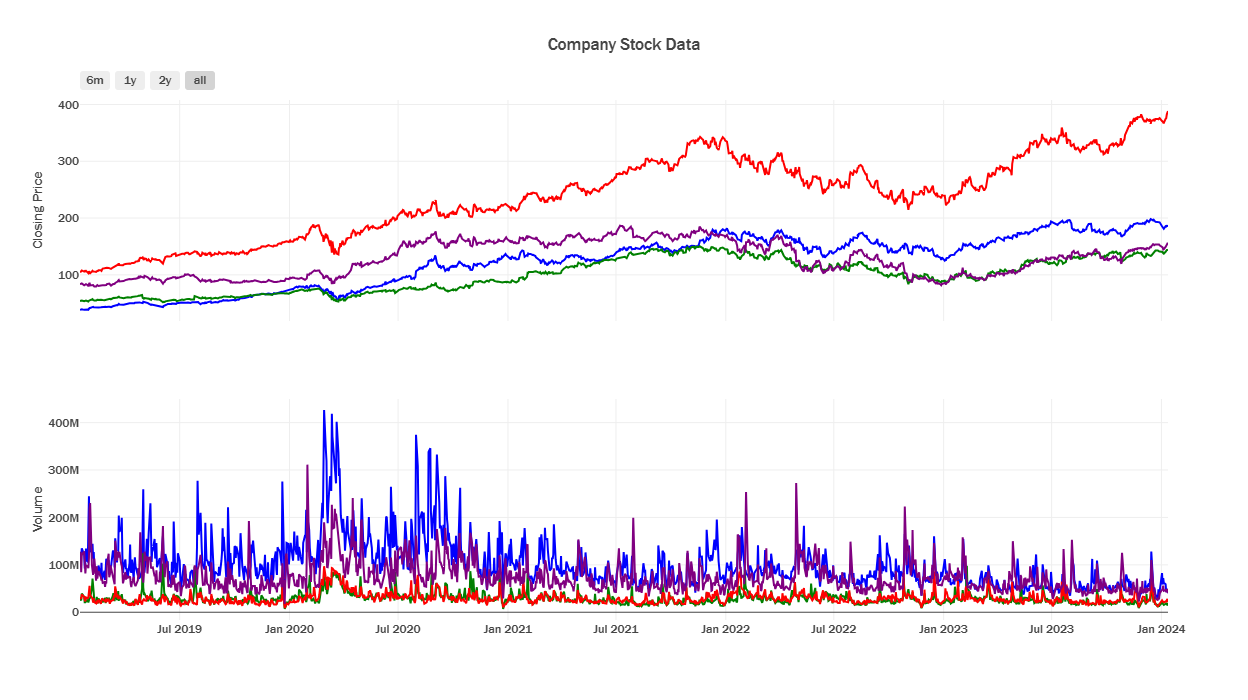

In [12]:
fig = make_subplots(rows=2, cols=1, 
                    shared_xaxes=True)
# Loop through each company and add traces for closing price and volume
colors = ['blue', 'green', 'red', 'purple']  # You can customize colors
for company in df['company_name'].unique():
    company_data = df[df['company_name'] == company]

    # Trace for Closing Price
    close_trace = go.Scatter(x=company_data['Date'], y=company_data['Close'],
                            mode='lines', name=f'{company} Closing Price',
                            marker_color=colors[df['company_name'].unique().tolist().index(company)])
    fig.add_trace(close_trace, row=1, col=1)

    # Trace for Volume
    vol_trace = go.Scatter(x=company_data['Date'], y=company_data['Volume'],
                           mode='lines', name=f'{company} Volume',
                           marker_color=colors[df['company_name'].unique().tolist().index(company)])
    fig.add_trace(vol_trace, row=2, col=1)

# Configure layout
fig.update_xaxes(rangeslider_visible=False,
                 rangeselector=dict(
                     buttons=list([
                         dict(count=6, label="6m", step="month", stepmode="backward"),
                         dict(count=1, label="1y", step="year", stepmode="backward"),
                         dict(count=2, label="2y", step="year", stepmode="backward"),
                         dict(step="all")])),
                 row=1, col=1)

fig.update_layout(template=temp, title='Company Stock Data', height=700,
                  yaxis1_title='Closing Price', yaxis2_title='Volume',
                  showlegend=False)
fig.show()

## Moving average
A moving average is a statistic that captures the average change in a data series over time. The average is taken over a specific period of time, like 10 days, 20 minutes, 30 weeks, or any time period the trader chooses.

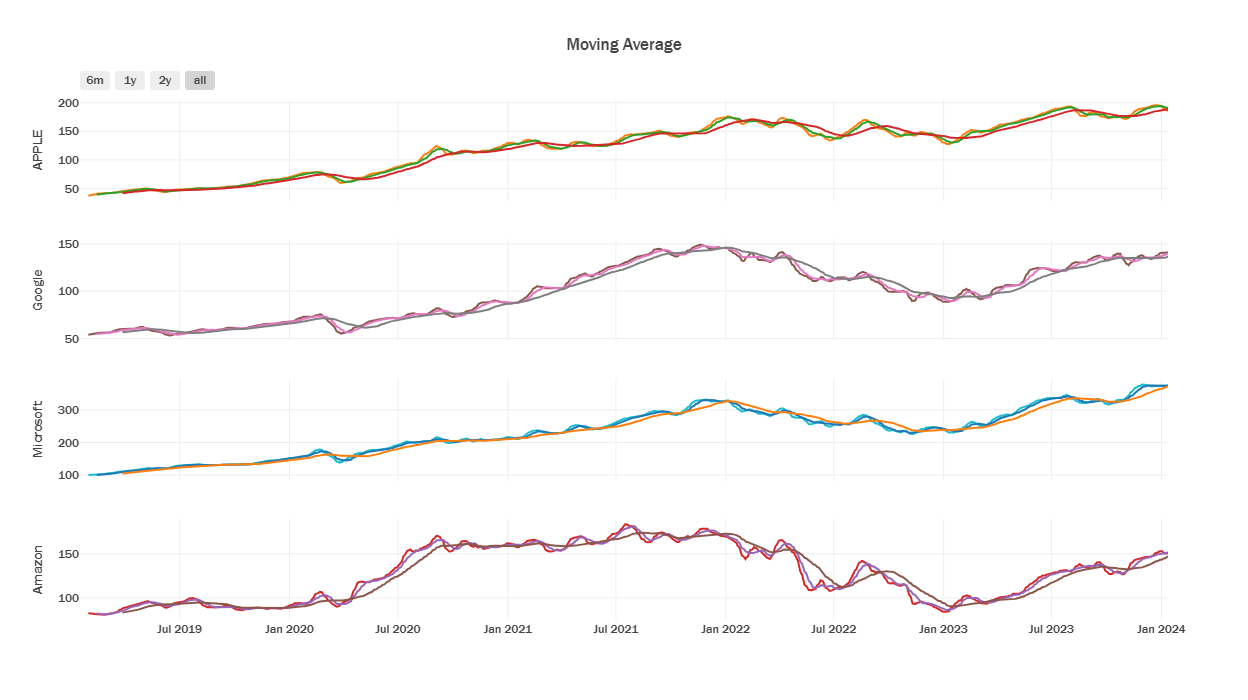

In [47]:

ma_day = [0, 10, 20, 50]

fig = make_subplots(rows=4, cols=1, 
                    shared_xaxes=True)
for i,company in enumerate(df['company_name'].unique()):
    company_data = df[df['company_name'] == company]
    for ma in ma_day:      
        
        close_trace = go.Scatter(x=company_data['Date'], y=company_data['Adj Close'].rolling(ma).mean(),
                            mode='lines', name=f'MA for {ma} days')
        
        fig.add_trace(close_trace, row=i+1, col=1)
        
    #fig.add_trace(close_trace, row=i+1, col=1)

# Configure layout
fig.update_xaxes(rangeslider_visible=False,
                 rangeselector=dict(
                     buttons=list([
                         dict(count=6, label="6m", step="month", stepmode="backward"),
                         dict(count=1, label="1y", step="year", stepmode="backward"),
                         dict(count=2, label="2y", step="year", stepmode="backward"),
                         dict(step="all")])),
                 row=1, col=1)

fig.update_layout(template=temp, title='Moving Average', height=700,
                  yaxis1_title='APPLE', yaxis2_title='Google', yaxis3_title='Microsoft', yaxis4_title='Amazon',
                  showlegend=False)
fig.show()

## Daily return

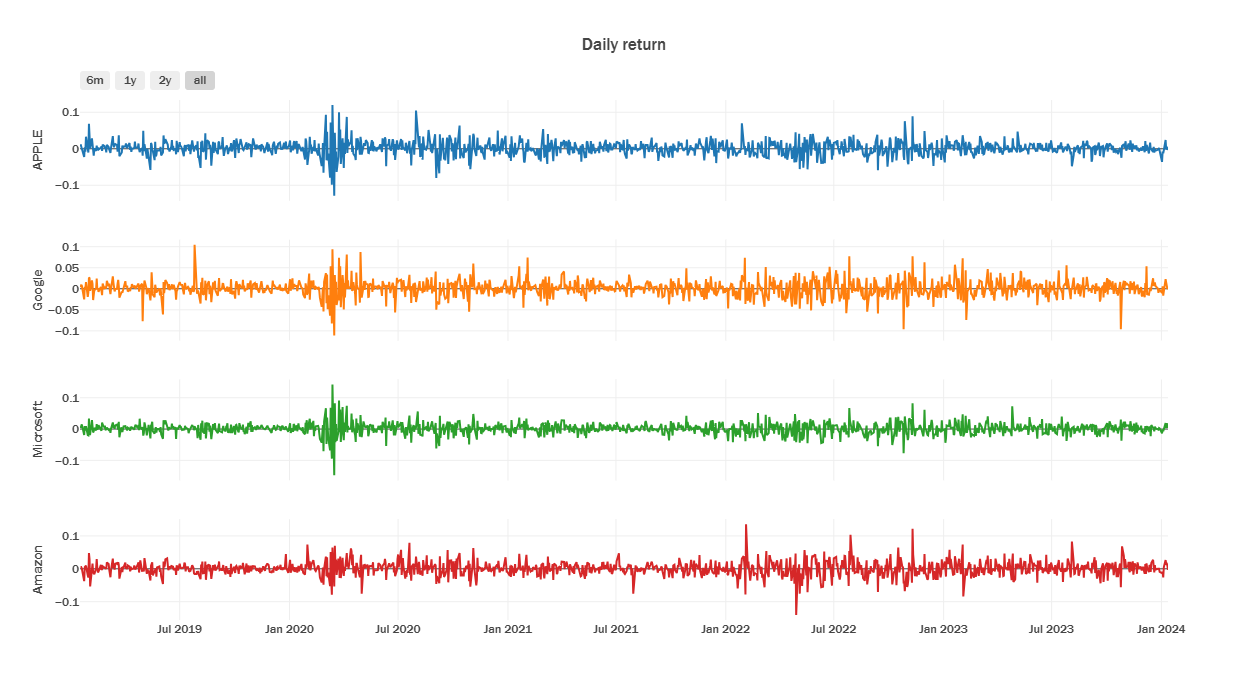

In [48]:
fig = make_subplots(rows=4, cols=1, 
                    shared_xaxes=True)
for i,company in enumerate(df['company_name'].unique()):
    company_data = df[df['company_name'] == company]      
        
    close_trace = go.Scatter(x=company_data['Date'], y=company_data['Adj Close'].pct_change(),
                            mode='lines', name=f'Daily Return')
        
    fig.add_trace(close_trace, row=i+1, col=1)
        
    #fig.add_trace(close_trace, row=i+1, col=1)

# Configure layout
fig.update_xaxes(rangeslider_visible=False,
                 rangeselector=dict(
                     buttons=list([
                         dict(count=6, label="6m", step="month", stepmode="backward"),
                         dict(count=1, label="1y", step="year", stepmode="backward"),
                         dict(count=2, label="2y", step="year", stepmode="backward"),
                         dict(step="all")])),
                 row=1, col=1)

fig.update_layout(template=temp, title='Daily return', height=700,
                  yaxis1_title='APPLE', yaxis2_title='Google', yaxis3_title='Microsoft', yaxis4_title='Amazon',
                  showlegend=False)
fig.show()

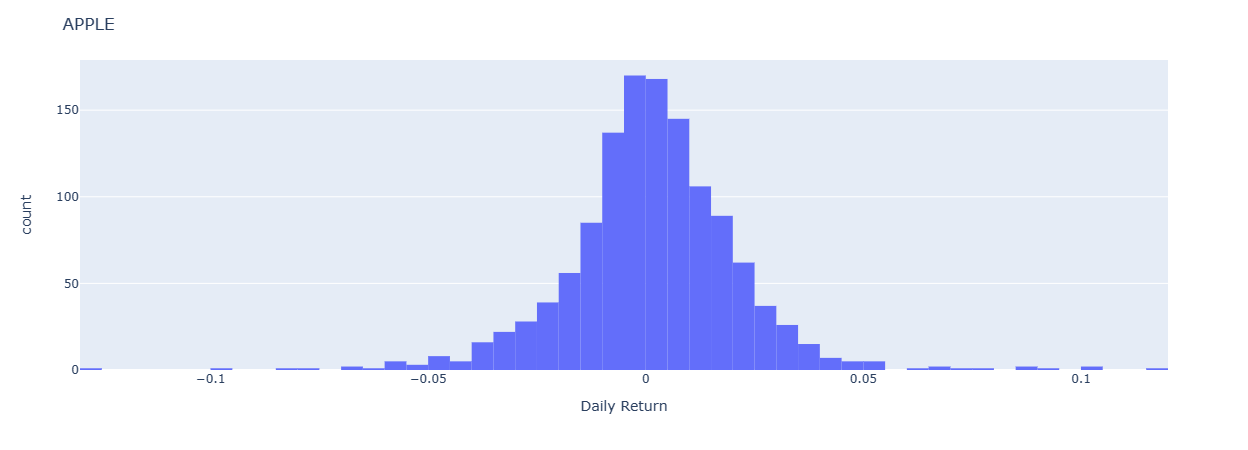

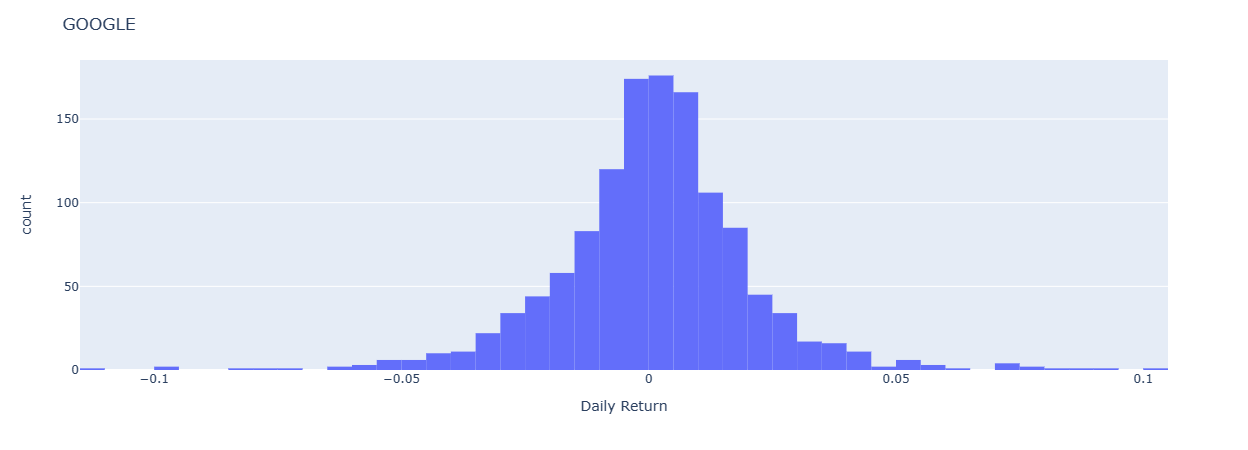

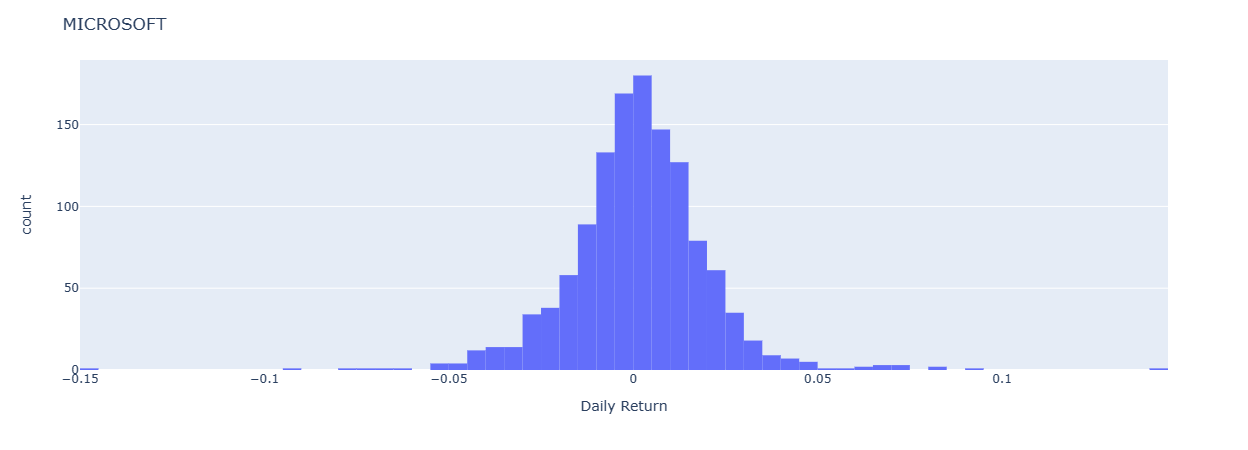

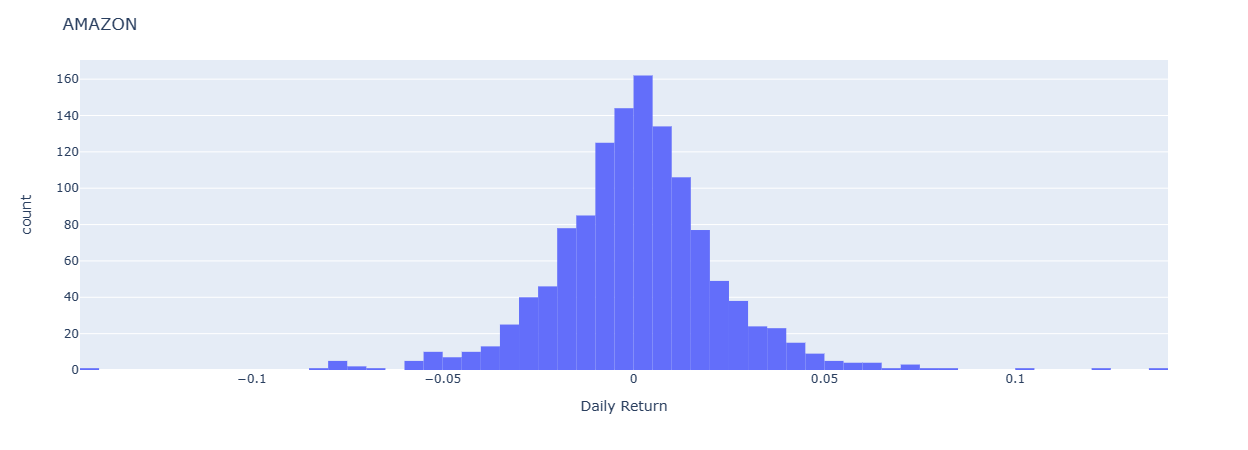

In [70]:


fig = make_subplots(rows=4, cols=1, 
                    shared_xaxes=True)
for i, company in enumerate(company_list, 1):
    fig = px.histogram(company,company['Daily Return'], nbins=100)
    fig.update_layout(title= company_name[i-1])
    fig.show()

## Correlation

In [71]:
# Grab all the closing prices for the tech stock list into one DataFrame

closing_df = pdr.get_data_yahoo(tech_list, start=start, end=end)['Adj Close']

# Make a new tech returns DataFrame
tech_rets = closing_df.pct_change()
tech_rets.head()

[*********************100%%**********************]  4 of 4 completed


AAPL      AMZN      GOOG      MSFT
Date                                              
2019-01-15       NaN       NaN       NaN       NaN
2019-01-16  0.012217  0.005506  0.003546  0.003523
2019-01-17  0.005938  0.005606  0.008261  0.007022
2019-01-18  0.006159  0.001760  0.007670  0.014983
2019-01-22 -0.022446 -0.037749 -0.025258 -0.018847

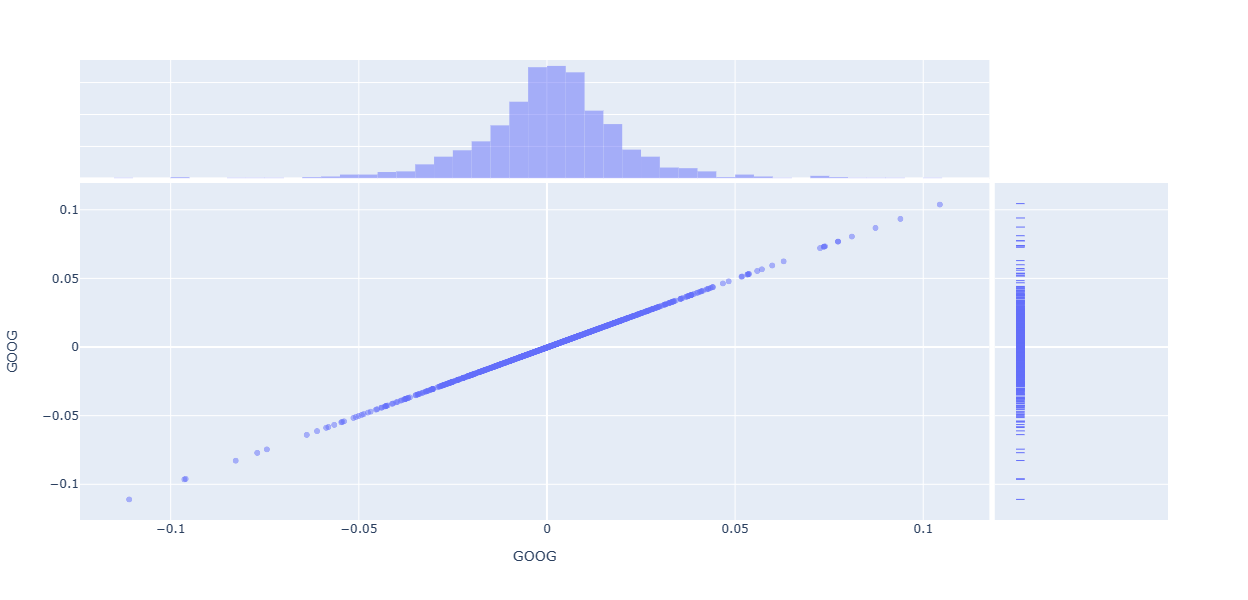

In [79]:
fig = px.scatter(tech_rets, x='GOOG', y='GOOG',marginal_x="histogram", marginal_y="rug", opacity=0.5, width=600, height=600)
fig.show()

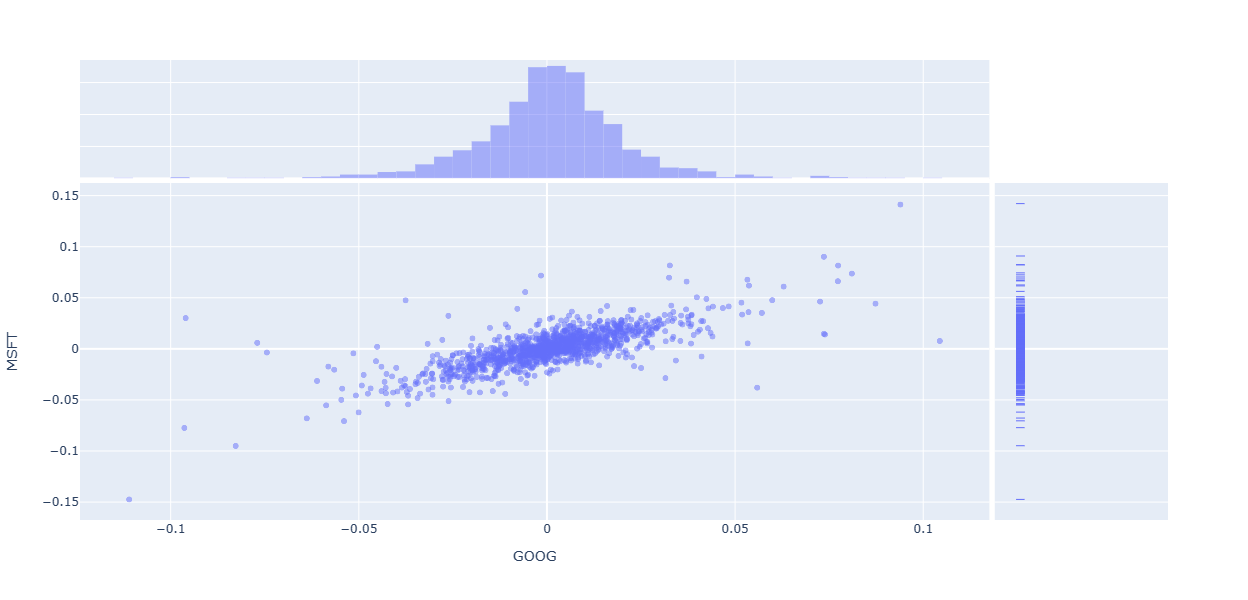

In [80]:
fig = px.scatter(tech_rets, x='GOOG', y='MSFT',marginal_x="histogram", marginal_y="rug", opacity=0.5, width=600, height=600)
fig.show()

In [82]:
tech_rets

AAPL      AMZN      GOOG      MSFT
Date                                              
2019-01-15       NaN       NaN       NaN       NaN
2019-01-16  0.012217  0.005506  0.003546  0.003523
2019-01-17  0.005938  0.005606  0.008261  0.007022
2019-01-18  0.006159  0.001760  0.007670  0.014983
2019-01-22 -0.022446 -0.037749 -0.025258 -0.018847
...              ...       ...       ...       ...
2024-01-08  0.024175  0.026577  0.022855  0.018872
2024-01-09 -0.002263  0.015225  0.014445  0.002936
2024-01-10  0.005671  0.015591  0.008698  0.018574
2024-01-11 -0.003223  0.009432 -0.000904  0.004859
2024-01-12  0.001778 -0.003609  0.003967  0.009984

[1258 rows x 4 columns]

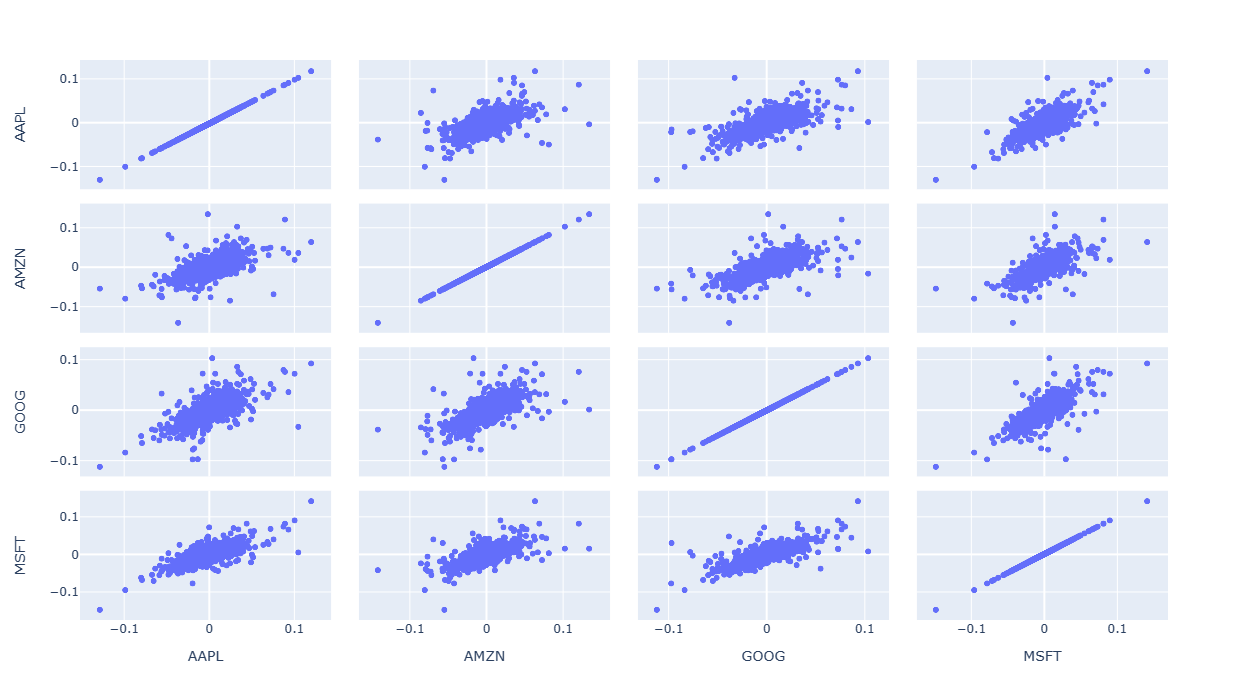

In [101]:
fig = px.scatter_matrix(tech_rets, height=700, width=700)
fig.show()

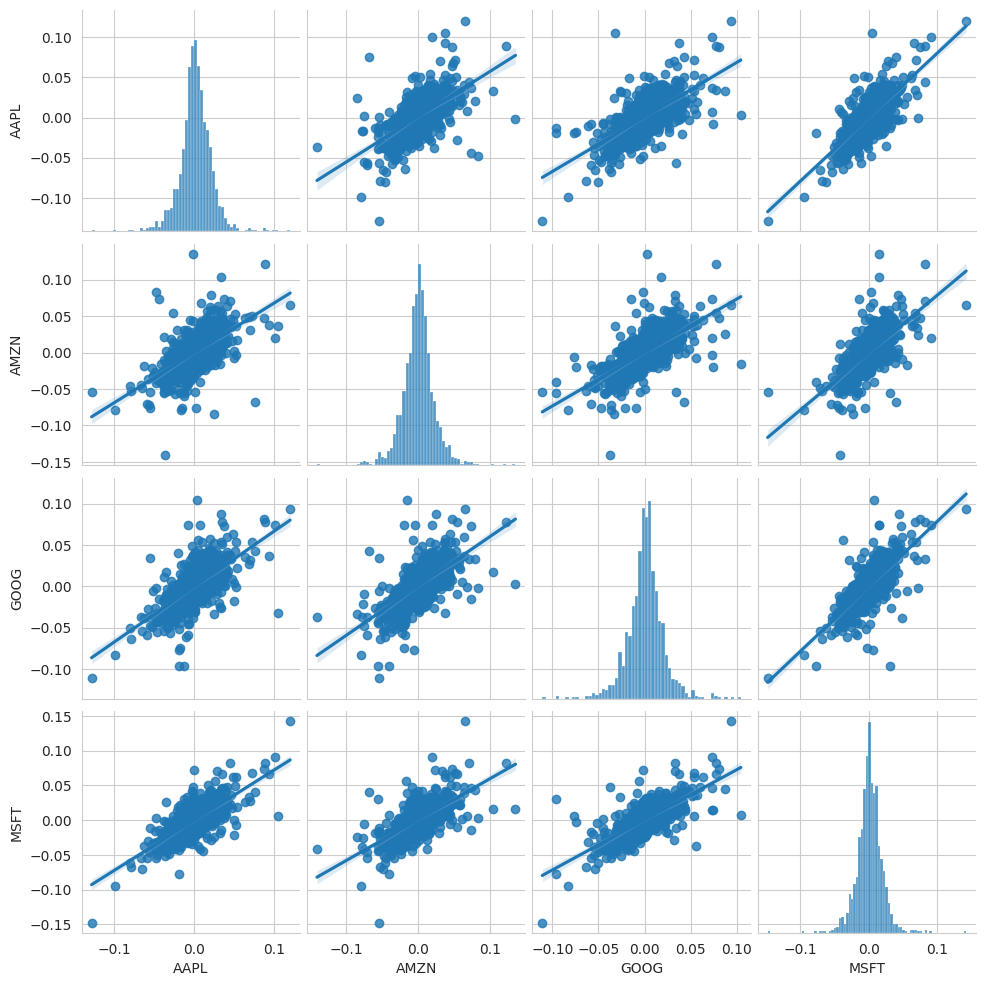

In [85]:
sns.pairplot(tech_rets, kind='reg')

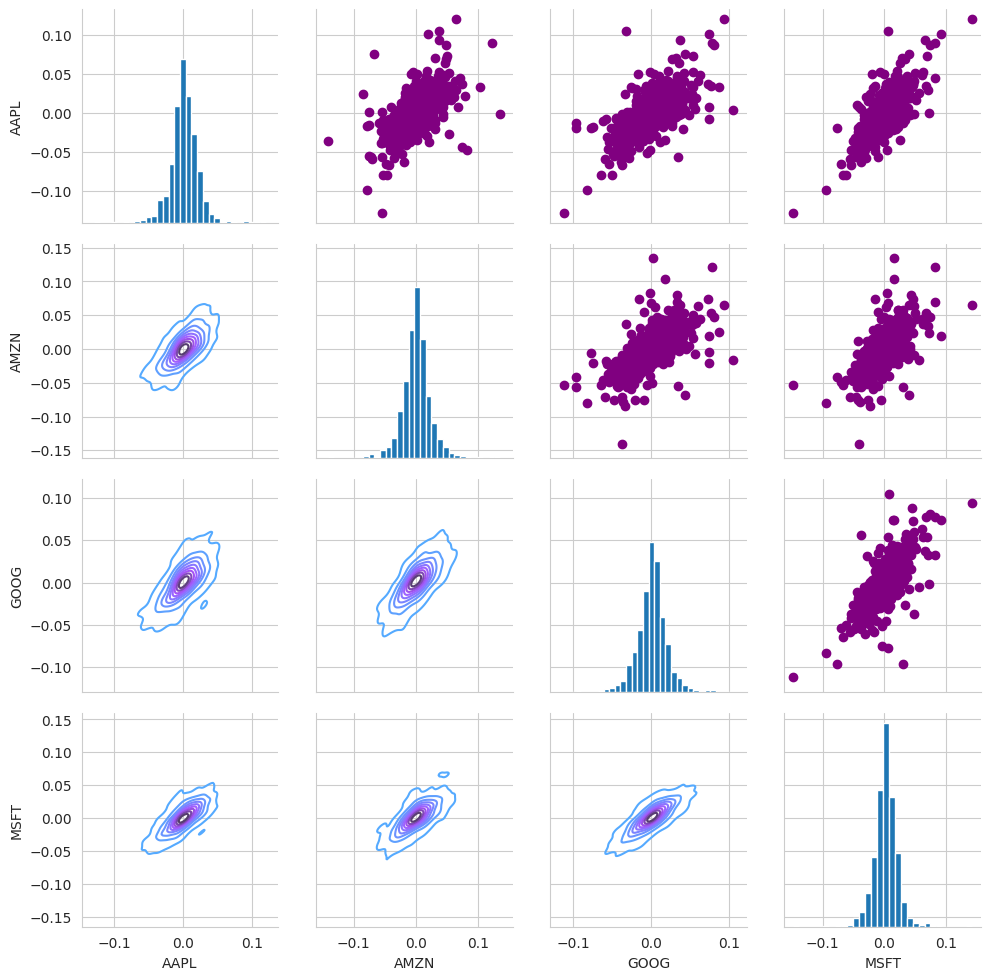

In [86]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
return_fig = sns.PairGrid(tech_rets.dropna())

# Using map_upper we can specify what the upper triangle will look like.
return_fig.map_upper(plt.scatter, color='purple')

# We can also define the lower triangle in the figure, inclufing the plot type (kde) 
# or the color map (BluePurple)
return_fig.map_lower(sns.kdeplot, cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
return_fig.map_diag(plt.hist, bins=30)

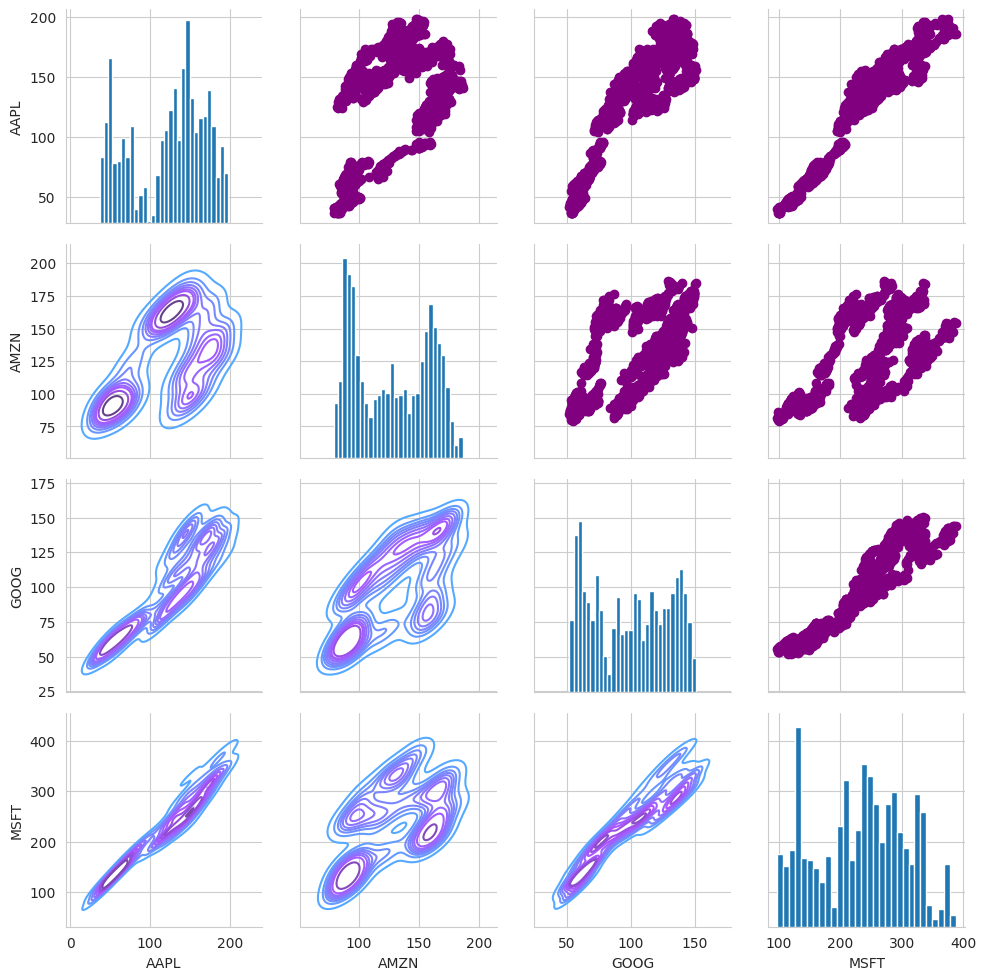

In [87]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
returns_fig = sns.PairGrid(closing_df)

# Using map_upper we can specify what the upper triangle will look like.
returns_fig.map_upper(plt.scatter,color='purple')

# We can also define the lower triangle in the figure, inclufing the plot type (kde) or the color map (BluePurple)
returns_fig.map_lower(sns.kdeplot,cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
returns_fig.map_diag(plt.hist,bins=30)

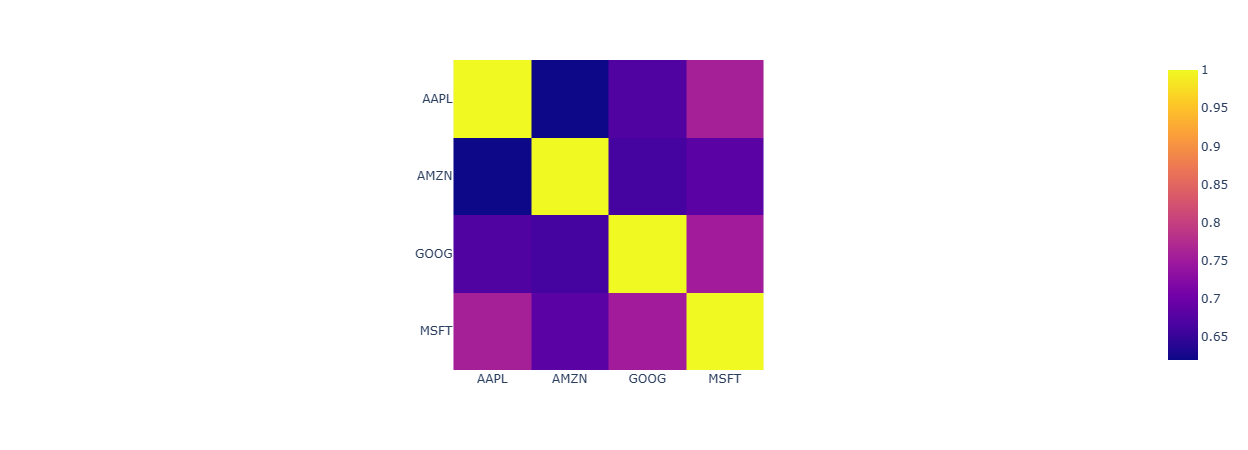

In [98]:
fig = px.imshow(tech_rets.corr(), text_auto=True)
fig.show()

## Return vs Risk

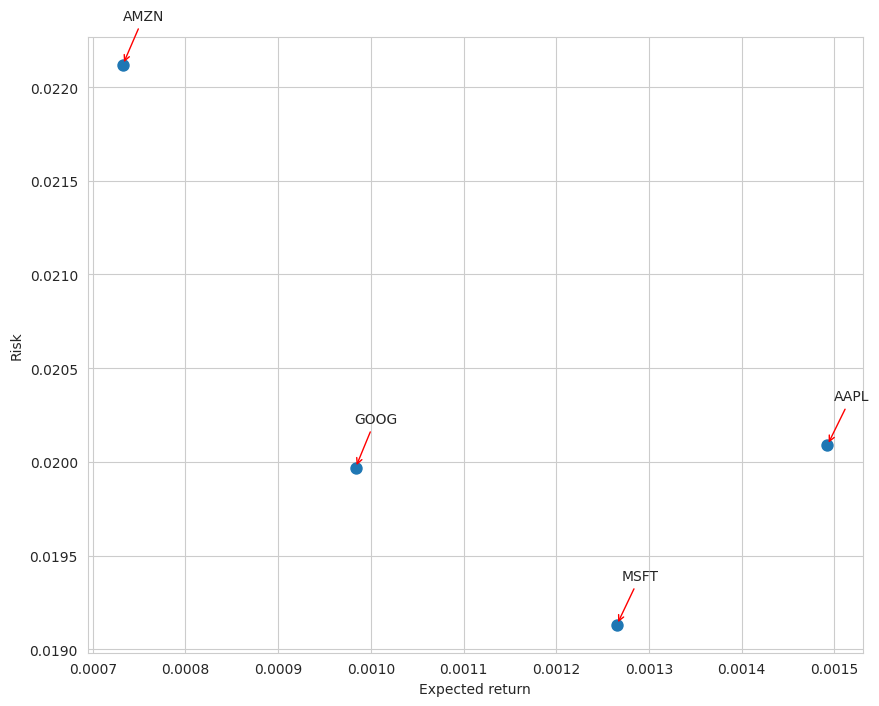

In [137]:
rets = tech_rets.dropna()

area = np.pi * 20

plt.figure(figsize=(10, 8))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')
for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x, y), xytext=(30, 30), textcoords='offset points', ha='right', va='bottom', 
                 arrowprops=dict(arrowstyle='->', color='red', connectionstyle='arc3'))

## Predicting growth of Microsoft

In [138]:
# Get the stock quote
df = pdr.get_data_yahoo('AAPL', start='2012-01-01', end='2023-12-31')
# Show teh data
df

[*********************100%%**********************]  1 of 1 completed


Open        High         Low       Close   Adj Close  \
Date                                                                     
2012-01-03   14.621429   14.732143   14.607143   14.686786   12.449690   
2012-01-04   14.642857   14.810000   14.617143   14.765714   12.516596   
2012-01-05   14.819643   14.948214   14.738214   14.929643   12.655557   
2012-01-06   14.991786   15.098214   14.972143   15.085714   12.787852   
2012-01-09   15.196429   15.276786   15.048214   15.061786   12.767570   
...                ...         ...         ...         ...         ...   
2023-12-22  195.179993  195.410004  192.970001  193.600006  193.600006   
2023-12-26  193.610001  193.889999  192.830002  193.050003  193.050003   
2023-12-27  192.490005  193.500000  191.089996  193.149994  193.149994   
2023-12-28  194.139999  194.660004  193.169998  193.580002  193.580002   
2023-12-29  193.899994  194.399994  191.729996  192.529999  192.529999   

               Volume  
Date                   
2012-01-03  302220800  
2012-01-04  260022000  
2012-01-05  271269600  
2012-01-06  318292800  
2012-01-09  394024400  
...               ...  
2023-12-22   37122800  
2023-12-26   28919300  
2023-12-27   48087700  
2023-12-28   34049900  
2023-12-29   42628800  

[3018 rows x 6 columns]

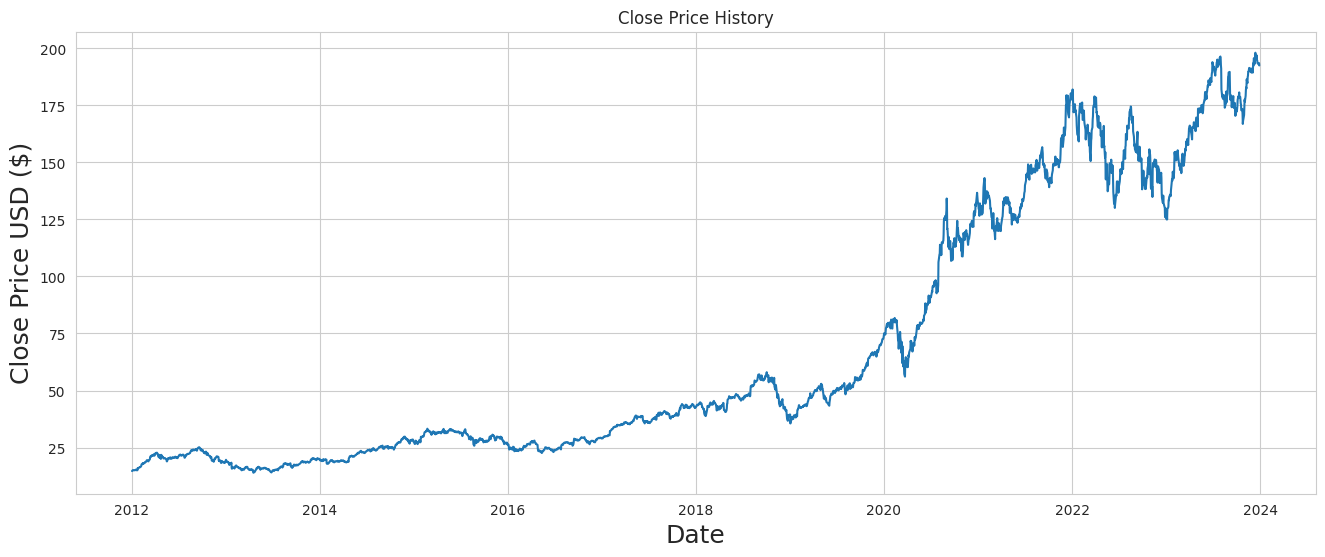

In [139]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [140]:
# Create a new dataframe with only the 'Close column 
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

2868

In [141]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00401431],
       [0.00444289],
       [0.00533302],
       ...,
       [0.97306723],
       [0.97540217],
       [0.96970066]])

In [142]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.00401431, 0.00444289, 0.00533302, 0.00618049, 0.00605056,
       0.00634339, 0.00620958, 0.00598462, 0.00567821, 0.00662652,
       0.00748175, 0.007218  , 0.00577323, 0.00715207, 0.00579457,
       0.01088518, 0.01049151, 0.01100542, 0.01211663, 0.01278955,
       0.01273332, 0.01252582, 0.01341013, 0.01424207, 0.01518457,
       0.01670691, 0.01990478, 0.01995326, 0.02173353, 0.02306387,
       0.02077746, 0.02165789, 0.02164044, 0.02410915, 0.02375813,
       0.02440779, 0.02557523, 0.0262249 , 0.02809631, 0.02945961,
       0.02985329, 0.02999098, 0.02765997, 0.02709757, 0.02718096,
       0.02937236, 0.02998905, 0.03131358, 0.03443581, 0.03860139,
       0.0378218 , 0.03782373, 0.04083544, 0.04177794, 0.04110694,
       0.04049413, 0.03985611, 0.04197573, 0.0434302 , 0.04403914])]
[0.042534249860459186]

[array([0.00401431, 0.00444289, 0.00533302, 0.00618049, 0.00605056,
       0.00634339, 0.00620958, 0.00598462, 0.00567821, 0.00662652,
       0.00748175, 0.007218  , 0.0

In [143]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2808/2808 [==============================] - 111s 38ms/step - loss: 0.0011


In [144]:
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

5/5 [==============================] - 1s 38ms/step


5.142754896825537

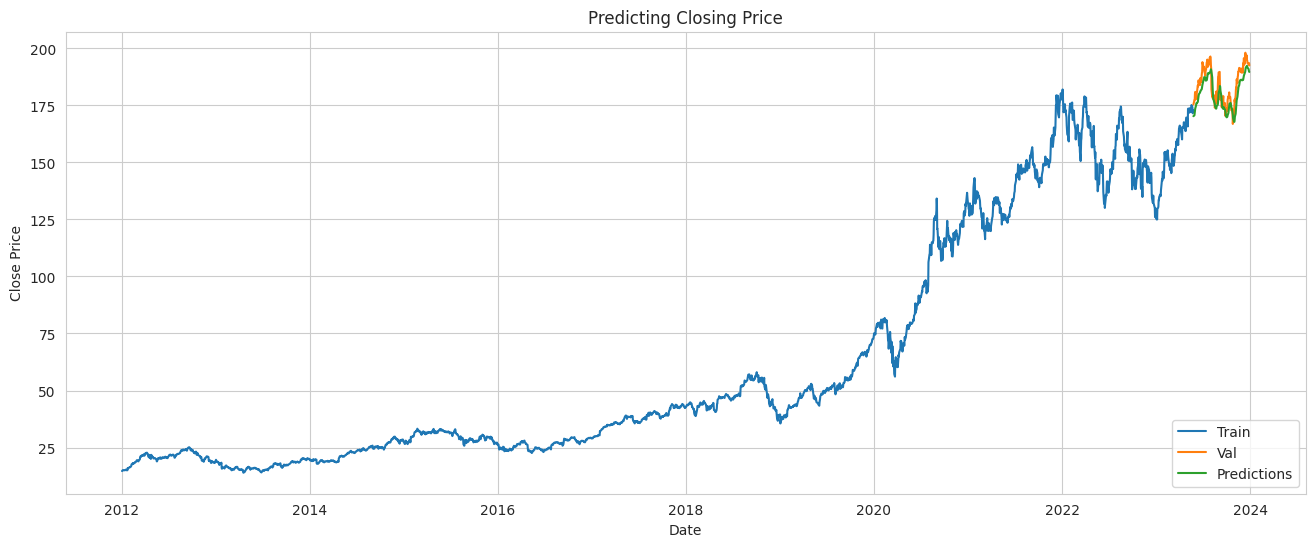

In [151]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Predicting Closing Price')
plt.xlabel('Date', fontsize=10)
plt.ylabel('Close Price', fontsize=10)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()